 # Craigslist Capstone Project - Modeling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay.

#### This notebook covers the scope of
Preprocessing and scaling numeric data. Splitting training and test data.

Building models:
1. Stochastic Gradient Descent Model
2. Random Forest Model
3. XGBoost
4. LGBM Regressor


For model metrics and evalution, choose mean absolute error (MAE) as the accuracy metric over RMSE because the data has a long right tail, so the RMSE gives a higher weight to large errors which distorts the accuracy of the model for the majority of listings. The MAE is more robust to outliers than RMSE, and as seen in the EDA portion, in the more expensive cities such as San Francisco, Oakland, Berkeley, Menlo Park, Palo Alto, there are more price outliers.  

The MAE is a better intuitive metric for this model as it reflects on average how far off the predicted price is from the actual price, where the units are in dollars. 
The mean absolute percentage error (MAPE) is also used as a metric because comparing the percentage error is easier across cities that could have high and low listing prices. 



## Importing the libraries

In [114]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from sklearn import __version__ as sklearn_version
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

## Load Data

In [115]:
# The data is the interim directory
df = pd.read_csv('/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_EDA.csv',index_col='listing_id')
# Drop listing_city 
df.drop(['listing_city'], axis=1, inplace=True)
df

,listing_nh,listing_price,listing_sqft,listing_address,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,...,is_rent_controlled,pets_allowed,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,fremont / union city / newark,3800,1495.0,Newport Dr,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
7520905091,vallejo / benicia,2100,904.0,226 Edgemont Avenue near Edgemont Avenue,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520907681,vallejo / benicia,2200,1420.0,1509 Sacramento Street near Sacramento Street,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520608095,dublin / pleasanton / livermore,3935,1266.0,1552 E Gate Way,1,1,1,0,1,0,...,0,0,1,1,0,0,0,1,0,0
7520200206,dublin / pleasanton / livermore,3000,NaN,2380 Nissen Drive,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539192775,downtown / civic / van ness,6775,2540.0,"1888 Geneva Ave, 403 near Carter",0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
7527460081,inner richmond,3500,1100.0,404 12th Ave #4 near Geary Blvd,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
7536441224,tenderloin,2195,NaN,725 Ellis St near Hyde,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
y = df['listing_price']
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1,shuffle=True)

In [117]:
X_train_preprocess = X_train.copy()

In [118]:
nh_listings_test = X_train.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
nh_listings_test.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
nh_listings_test

,listing_nh,no_bedrooms,average_price_by_nh_by_bedroom
0,SOMA / south beach,0,2533.928571
1,SOMA / south beach,1,3589.194631
2,SOMA / south beach,2,4959.759398
3,SOMA / south beach,3,5354.740741
4,SOMA / south beach,4,5547.500000
...,...,...,...
411,western addition,0,2472.666667
412,western addition,1,2853.777778
413,western addition,2,4150.000000
414,western addition,4,5250.000000


In [119]:
nh_listings_test['average_price_by_nh_by_bedroom'].mean()

4149.834258521039

In [120]:
y_train.shape, y_test.shape

((8677,), (3719,))

In [121]:
# Save the index to put back after scaling
X_train_index = X_train.index
X_test_index = X_test.index

## 2. Handle missing values

In [122]:
missing = pd.concat([X_train.isnull().sum(), 100 * X_train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,2723,31.381814
transit_score,1649,19.004264
bike_score,1174,13.530022
walk_score,255,2.938804
listing_address,205,2.362568
listing_nh,0,0.000000
is_rent_controlled,0,0.000000
housing_flat,0,0.000000
housing_house,0,0.000000
housing_townhouse,0,0.000000


The missing addresses are ok to ignore since we will not be using that feature directly. The neighborhood and walk_score, transit_score, bike_scores are better representations of how desirable a property is compared to the exact address.

### Impute any missing square footage values 
Let's use the median value for the listing's number of bedroom/bathroom

In [123]:
class ImputeMissingSqft:
        
    def fit(self, X, y=None):
        # Group by bedrooms and bathrooms to find median square footage
        self.missing_sqft = X.groupby(by=['no_bedrooms','no_bathrooms']).median()['listing_sqft'].reset_index()
        self.missing_sqft.rename(columns = {'listing_sqft':'listing_sqft_median'}, inplace = True)
        mean_sqft_by_bedroom = self.missing_sqft.groupby(by='no_bedrooms').mean().reset_index()[['no_bedrooms','listing_sqft_median']]
        
        # Create a dictionary of the average sqft by bedrooms
        self.mean_sqft_by_bedroom_dict = mean_sqft_by_bedroom.set_index('no_bedrooms').to_dict()['listing_sqft_median']
        
        # Fillna for the missing values in the dictionary
        self.missing_sqft.loc[self.missing_sqft['listing_sqft_median'].isnull(),'listing_sqft_median'] = self.missing_sqft['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict)
        return self
    
    def transform(self, X):
        # Left join on bedrooms and bathrooms and use the median column if listing_sqft is null
        combined_df = X.merge(self.missing_sqft, on=['no_bedrooms','no_bathrooms'], how='left')
        
        combined_df['listing_sqft'].fillna(combined_df['listing_sqft_median'], inplace=True)
        
        # Fillna with the median listing_sqft value by bedroom only if it is a combination not seen before
        combined_df['listing_sqft'].fillna(combined_df['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict), inplace=True)
        
        # Drop the extra column
        combined_df.drop(['listing_sqft_median'], axis=1, inplace=True)
        X = combined_df
        return X

### Impute any missing Walk score, Transit Score, Bike Score values
Let's use the median value for the listing's neighborhood. All transit scores range from 0 to 100

In [124]:
class ImputeMissingWalkscore:
        
    def fit(self, X, y=None):
        # Group by neighborhood to find median walks_score, transit_score, bike_score
        self.median_scores = X.groupby(by=['listing_nh']).median()[['walk_score','transit_score','bike_score']].reset_index()
        self.median_scores.rename(columns = {'walk_score':'median_walk_score','transit_score':'median_transit_score','bike_score':'median_bike_score'}, inplace = True)
        self.median_scores.fillna(0, inplace=True)
        return self
    
    def transform(self, X):
        # Left join on neighborhoods
        nh_df = X.merge(self.median_scores, on=['listing_nh'], how='left')

        # Use the mean score values if walk_score, transit_score or bike_score is null
        nh_df['walk_score'].fillna(nh_df['median_walk_score'],inplace=True)
        nh_df['transit_score'].fillna(nh_df['median_transit_score'],inplace=True)
        nh_df['bike_score'].fillna(nh_df['median_bike_score'],inplace=True)

        # In case there is a new neighborhood that doesn't have a mean walk/bike/transit score, use the mean of median_scores to fill null values
        nh_df['walk_score'].fillna(self.median_scores['median_walk_score'].mean(),inplace=True)
        nh_df['transit_score'].fillna(self.median_scores['median_transit_score'].mean(),inplace=True)
        nh_df['bike_score'].fillna(self.median_scores['median_bike_score'].mean(),inplace=True)
        
        # Drop unused columns
        nh_df.drop(['median_walk_score','median_transit_score','median_bike_score','listing_address'], axis=1,inplace=True)

        X = nh_df
        return X

## 4. Remove outliers
### For studio listings
During EDA, it became clear that studio listing prices had a very long tail - possibly because some listings were misclassified as studios when they should have been 1 or 2 bedroom apartments. 
To remove these outliers, cap the prices of studios to the 99th percentile

In [125]:
class RemoveOutliersStudios:
    def fit(self, X, y=None):
        # Cap the top 1% percentile of all listing_price for studios
        self.upper_lim = X[X['no_bedrooms'] == 0]['listing_price'].quantile(q = 0.99)
        return self
    
    def transform(self, X):
        X.loc[(X['listing_sqft'] > self.upper_lim) & (X['no_bedrooms'] == 0),'listing_price'] = self.upper_lim
        # Drop listing_price column
        X.drop(['listing_price'], axis=1, inplace=True)
        
        return X

### For listing square footage grouped by number of bedrooms

In [126]:
class CapOutliersSquareFootageByBedroom:
    def fit(self, X, y=None):
        grouped_bed_median = X.groupby(by=['no_bedrooms']).median()[['listing_sqft']].reset_index()
        grouped_bed_std = X.groupby(by=['no_bedrooms']).std()[['listing_sqft']].reset_index()
        self.sqft = pd.merge(grouped_bed_median, grouped_bed_std, on = "no_bedrooms", how = "inner")
        self.sqft.rename(columns = {'listing_sqft_x':'median_sqft', 'listing_sqft_y':'std_sqft'}, inplace = True)
        
        # Calculate the upper limit
        self.sqft['upper_lim'] = self.sqft.apply(lambda row: row['median_sqft'] + row['std_sqft'] * 3, axis = 1).astype(int)
        return self
    
    def transform(self, X):
        X = X.merge(self.sqft[['no_bedrooms','upper_lim']], on=['no_bedrooms'], how='left')
        X['listing_sqft'] = np.where((X['listing_sqft'] > X['upper_lim']), X['upper_lim'], X['listing_sqft'])
        # Drop upper_lim column
        X.drop(['upper_lim'], axis=1, inplace=True)
        return X

## 5. Feature engineering for categorical variables
The remaining categorical features are neighborhood and city. Since a city includes multiple neighborhoods, we can use the neighborhood feature in lieu of the city feature entirely. 
The most common size of rental units are 1 bedroom/1 bathroom ones. There are too many neighborhoods to one hot encode so instead impute using the mean price per 1 bedroom/1 bathroom listing for that neighborhood or city. 

Let's create or own Estimator to replace the categorical feature neighborhoods to the average listing price of 1 bedroom/1 bathroom places for each neighborhood. 

In [127]:
# List all the unique neighborhoods in the entire dataset
unique_nh = df.listing_nh.unique()
print(f'There are {len(unique_nh)} unique neighborhoods in the dataframe')

There are 82 unique neighborhoods in the dataframe


In [128]:
class NHAveragePrice:

# # Option 1: Group by neighborhood and number of bedrooms
#     def fit(self, X, y=None):
#         # Group by neighborhood and number of bedrooms
#         self.nh_listings = X.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
#         self.nh_listings.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         return self
    
#     def transform(self, X):
#         combined_df = X.merge(self.nh_listings, on=['listing_nh','no_bedrooms'], how='left')
#         combined_df.rename(columns = {'listing_price_y':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         # If there is a combination of neighborhood and bedroom number not seen in the training set, impute the median price
#         combined_df['average_price_by_nh_by_bedroom'].fillna(self.nh_listings['average_price_by_nh_by_bedroom'].mean(), inplace=True)
#         X = combined_df
#         return X
    
# Option 2: Group by neighborhood and square footage

    def fit(self, X, y=None):
        # Group by neighborhood and square footage
        X['price_per_sqft'] = X['listing_price']/X['listing_sqft']
        self.nh_price = X.groupby(['listing_nh'])['price_per_sqft'].mean().reset_index()
        X.drop(['price_per_sqft'], axis=1, inplace=True)

        return self
    
    def transform(self, X):
        avg_nh_df = X.merge(self.nh_price, on=['listing_nh'], how='left')
        
        # If there is a neighborhood not seen in the training set, impute the median value for all neighborhoods
        avg_nh_df['price_per_sqft'].fillna(self.nh_price['price_per_sqft'].median(), inplace=True)
        avg_nh_df['price_estimate_sqft_nh'] = avg_nh_df['price_per_sqft'] * avg_nh_df['listing_sqft']
        avg_nh_df.drop(['listing_nh'], axis=1,inplace=True)
        X = avg_nh_df
        return X


## 6. Standardize numeric features

In [129]:
# class DataframeMinMaxScaler:
#     def __init__(self, columns):
#         self.columns = columns
#         self.scaler = MinMaxScaler()
        
#     def fit(self, X, y=None):
#         self.scaler.fit(X[self.columns])
#         return self
    
#     def transform(self, X):
#         X[self.columns] = self.scaler.transform(X[self.columns])
#         return X
    
class DataframeStandardScaler:
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [130]:
nh = NHAveragePrice()
sqft1 = ImputeMissingSqft()
walk = ImputeMissingWalkscore()
outliers = RemoveOutliersStudios()
sqft2 = CapOutliersSquareFootageByBedroom()
scale = DataframeStandardScaler(['listing_sqft','walk_score','transit_score','bike_score','no_bedrooms','no_bathrooms','price_per_sqft','price_estimate_sqft_nh'])

p = Pipeline([
    ('impute_missing_sqft', sqft1),
    ('impute_missing_walkscore', walk),
    ('nh_average_price', nh),
    ('remove_outliers_studios', outliers),
    ('Cap_Outliers_Square_Footage_By_Bedroom', sqft2),
    ('standard_scaler', scale)
])

X_train = p.fit_transform(X_train)
X_test = p.transform(X_test)

In [131]:
# Assign index back
X_train.index = X_train_index
X_test.index = X_test_index
X_train

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh
listing_id,,,,,,,,,,,,,,,,,,,,,
7540947998,-0.638730,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.275789,-0.526374
7521266991,-1.088737,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.028558,-1.215431
7536497502,-1.088737,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1.275804,-0.802526
7548144379,-0.871128,0,0,1,0,0,1,0,1,0,...,1,1,0,0,0,0,0,0,-0.449012,-0.920352
7536588638,-0.670421,1,1,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,-1.891344,-1.113177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541405682,-1.088737,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1.037754,-0.845181
7514268290,-0.216188,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1.253184,0.232866
7537556465,-1.061272,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-1.028026,-1.194119


In [132]:
print(f'There are {X_train.isnull().sum().sum()} missing rows in X_train')
print(f'There are {X_test.isnull().sum().sum()} missing rows in X_test')

There are 0 missing rows in X_train
There are 0 missing rows in X_test


In [133]:
X_test.price_per_sqft.describe()

count    3719.000000
mean       -0.018008
std         1.007038
min        -2.131872
25%        -0.812286
50%        -0.100098
75%         0.881478
max         2.112435
Name: price_per_sqft, dtype: float64

In [134]:
# Create another version of df that is unscaled but transformed for graphing purposes only

# df_nonscaled = pd.concat([X_train, X_test])
# listing_prices = pd.concat([y_train, y_test])
# df_nonscaled = pd.concat([df_nonscaled, listing_prices], axis=1, join='inner')
# df_nonscaled
# df_nonscaled.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/df_nonscaled.csv', header=True)
# print('Saved to csv file')

In [135]:
# Open df_nonscaled from csv file for plotting purposes
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
df_nonscaled = pd.read_csv(dir_folder + 'df_nonscaled.csv',index_col='listing_id')

### The Data:
We have the following variables for each unit/listing:

| Column name    | Datatype    | Description                                      |
|:---------------|:------------|:-------------------------------------------------|
|listing_sqft|float|The unit's area measured in square foot|
|animals_cats|boolean|Allows cats |
|animals_dogs|boolean|Allows dogs |
|smoking|boolean|Allows smoking|
|wheelchair accessible|boolean|Is wheelchair accessible|
|has_AC|boolean|Has Air Conditioning|
|hasEVCharging|boolean|Has Electric Charging for vehicles|
|laundry_in_bldg|boolean|The unit has laundry in the building but not inside the unit|
|laundry_in_unit|boolean|The unit has laundry in the unit|
|laundry_has_hookup|boolean|The unit has no laundry but can be installed|
|laundry_onsite|boolean|The unit has laundry onsite but outside the building|
|laundry_not_onsite|boolean|The unit does not have any laundry options|
|parking_carport|boolean|Has parking in a carport|
|parking_attached_garage|boolean|Has parking in an attached garage|
|parking_detached_garage|boolean|Has parking in a detached garage|
|parking_offstreet|boolean|Has parking offstreet e.g. driveway|
|parking_street|boolean|Has street parking|
|parking_valet|boolean|Has valet parking|
|parking_none|boolean|Has no parking options|
|rent_period_monthly|boolean|The unit is rented on a monthly basis|
|housing_condo|boolean|The unit is a condominium|
|housing_apt|boolean|The unit is an apartment|
|housing_flat|boolean|The unit is a flat|
|housing_house|boolean|The unit is a house|
|housing_townhouse|boolean|The unit is a townhouse|
|walk_score|float|A measure of the walkability of the unit's surroundings - measured from 0 to 100, the higher the better|
|transit_score|float|A measure of how good the transit options are near the unit - measured from 0 to 100, the higher the better|
|bike_score|float|A measure of the bikeability of the unit's surroundings - measured from 0 to 100, the higher the better|
|no_bedrooms|float|The number of bedrooms in the unit|
|no_bathrooms|float|The number of bathrooms in the unit|
|is_rent_controlled|boolean|Is the unit rent controlled by local rental laws|
|pets_allowed|boolean|Does the unit allow pets - this could be animals other than cats or dogs|
|has_amenities|boolean|Does the unit have amenities (pool, gym, spa) for use|
|premium_finishes|boolean|Does the unit have any premium finishes: granite, marble, walnut, millwork, a fireplace, built-in cabinetry|
|ensuite_bath|boolean|Does the unit have an ensuite bathroom|
|has_balcony|boolean|Does the unit have balconies|
|has_backyard|boolean|Does the unit have a backyard|
|has_view|boolean|Does the unit have views/or is a penthouse|
|multi-level|boolean|Is the unit a multi-level 3, 4 or 5 story house|
|is_an_SRO|boolean|Is the unit an SRO. An SRO is a single room occupancy, generally room only, with access to shared bathroom and kitchen|
|price_per_sqft|float|The average price per square foot of listings in the unit's neighborhood|
|price_estimate_sqft_nh|float|The price_per_sqft multiplied by the unit's square footage value|



# Machine Learning Models

### Define functions to train and evaluate models, with cross validation

In [136]:
def train_model(model, param_grid, cv, metric, X_train, y_train):
    # Perform grid search cross validation to find the best parameters
    cv = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, refit = True, scoring=metric, verbose=1)
    cv.fit(X_train, y_train)
    best_model = cv.best_estimator_
    print(f'Cross Validation best parameters: {cv.best_params_}')
    
    return best_model

def evaluate_model(model, X_test, y_test):
    # predict using the model
    y_pred = model.predict(X_test)
    
    # Metrics
    r_score = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100

    print(f'R2 score: {r_score:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.1f}%')
    metrics_dict = {'Model':model, 'R2 score':r_score, 'RMSE score':rmse, 'MAE score':mae, 'MAPE score %':mape}
    
    return metrics_dict

def pred_scatterplot(y_pred, y_test, model):
    sns.set(rc={"figure.figsize":(12, 6)})
    ax = sns.scatterplot(y=y_pred, x=y_test, palette='Paired_r')
    xpoints = ypoints = ax.get_xlim()
    ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
    plt.title(f'Actual vs. Predicted Rent Prices - {model} Model')
    plt.ylabel('Predicted values $ (y_pred)')
    plt.xlabel('Actual values $ (y_test)')
    return plt.show()

def residual_barplot(y_pred, y_test, model):
    sns.set(rc={"figure.figsize":(12, 6)})
    residuals_as_prices = y_test - y_pred
    # Plot test set with missing sqft that was imputed
    s = sns.histplot(residuals_as_prices)
    plt.ylabel('Density')
    plt.xlabel('Residual $ (y_pred - y_test)')
    plt.title(f'Residual Density for {model} model')
    return plt.show()


## 1. Stochastic Gradient Descent

In [137]:
# Stochastic gradient descent

param_grid = { 
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25],
    'max_iter': [500,1000,1500]
}

model_sgd = train_model(SGDRegressor(penalty='elasticnet'), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_sgd = evaluate_model(model_sgd, X_test, y_test)
y_pred_sgd = model_sgd.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Cross Validation best parameters: {'alpha': 0.0001, 'max_iter': 1500}
R2 score: 0.78
RMSE: 715.25
MAE: 467.06
MAPE: 14.2%


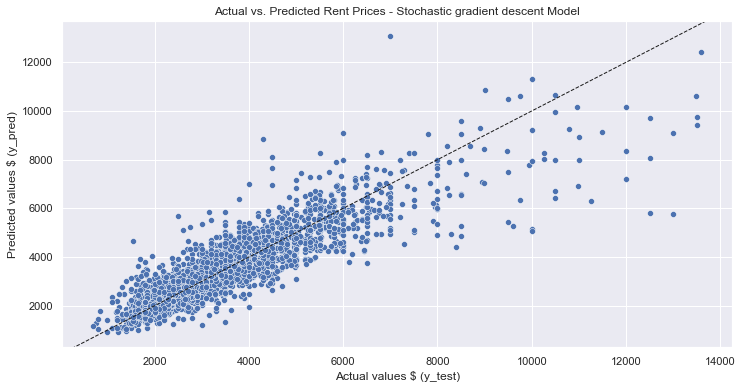

In [138]:
pred_scatterplot(y_pred_sgd, y_test, 'Stochastic gradient descent')

The model is predicting lower prices for a listing than the actual price as prices increase.
Let's look into the proportions of residual distribution. Define a low residual as one where the model has closely predicted the listing price. A medium residual to be an ok prediction but off by a few hundred, and a high residual as a predicted value that wouldn't help inform the user. 

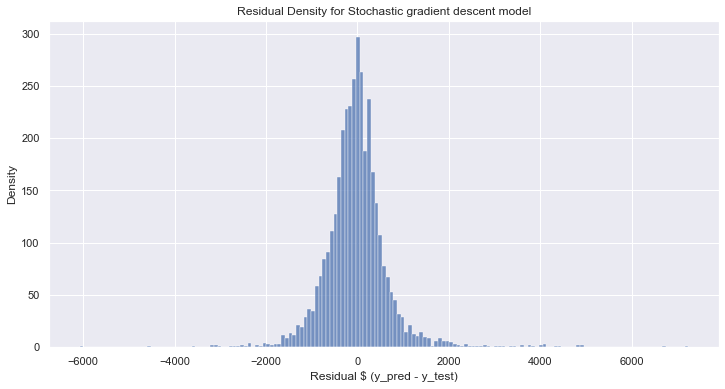

In [139]:
residual_barplot(y_pred_sgd, y_test, 'Stochastic gradient descent')

In [140]:
# Define low, med, high residuals
X_test_size = X_test.shape[0]

low_residual = 100
med_residual = 500
high_residual = 1000

# Also useful to compare percentages of the listing price
low_residual_percent = 0.15

# Residual = predicted - actual list price
residual = pd.DataFrame(y_test - y_pred_sgd)

residual.rename(columns = {'listing_price':'price_residual'}, inplace = True)
residual

,price_residual
listing_id,
7537721764,879.841151
7511018326,-513.601898
7507844762,-580.087244
7512271587,122.523408
7547170537,-656.845943
...,...
7540201361,486.115420
7537691238,121.735209
7547516171,334.313968


In [141]:
residual['listing_price'] = y_test
residual['residual_percent'] = residual['price_residual']/residual['listing_price']
residual['residual_category'] = np.where(np.abs(residual['residual_percent'])<low_residual_percent, 'Within_15_percent', 'More_than_15_percent')
# Drop duplicated index
# residual = residual.groupby(residual.index).first()
residual

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7537721764,879.841151,5750,0.153016,More_than_15_percent
7511018326,-513.601898,3988,-0.128787,Within_15_percent
7507844762,-580.087244,1175,-0.493691,More_than_15_percent
7512271587,122.523408,4695,0.026097,Within_15_percent
7547170537,-656.845943,2627,-0.250037,More_than_15_percent
...,...,...,...,...
7540201361,486.115420,2895,0.167916,More_than_15_percent
7537691238,121.735209,3400,0.035804,Within_15_percent
7547516171,334.313968,3100,0.107843,Within_15_percent


Text(0.5, 1.0, 'Residual Density as a proportion of listing price for Linear Regression')

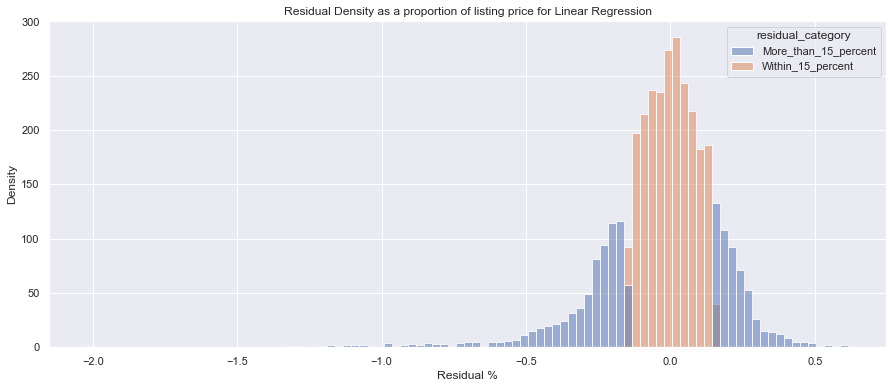

In [142]:
# Plot the distribution of residuals as a percentage
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(data = residual, x='residual_percent', hue='residual_category')
plt.ylabel('Density')
plt.xlabel('Residual %')
plt.title('Residual Density as a proportion of listing price for Linear Regression')

The long right tail in the residual plot suggets the model is predicting higher values than what is actually listed as the rental price. This could be because the model is identifying good deals where the unit is being rented for a price below market value. This information could be very informative to renters who are in the rental market.

In [143]:
residual[residual['residual_percent'] < -1]

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7548133532,-4540.672046,4300,-1.055970,More_than_15_percent
7521065678,-933.341179,850,-1.098048,More_than_15_percent
7546292747,-1638.867039,1500,-1.092578,More_than_15_percent
7545599410,-2094.487066,1950,-1.074096,More_than_15_percent
7519114049,-3179.814284,2498,-1.272944,More_than_15_percent
7542696603,-1984.816238,1650,-1.202919,More_than_15_percent
7515835373,-3130.267537,1550,-2.019527,More_than_15_percent
7546852430,-2010.206435,1800,-1.116781,More_than_15_percent
7547713831,-2235.258906,1700,-1.314858,More_than_15_percent


In [144]:
# Look at the high_residual rows
index_of_interest_high = residual[(residual['price_residual'] > high_residual) | (residual['price_residual'] < -high_residual)].index
print(f'Results for X_test with missing square footage values imputed:')
print(f'There are {len(index_of_interest_high)} rows that have residuals greater than {high_residual} between actual and predicted price, which is {(len(index_of_interest_high)/X_test_size)*100:.1f}% of all rows')

# Look at the med_residual rows
index_of_interest_med = residual[(residual['price_residual'] < med_residual) & (residual['price_residual'] > -med_residual)].index
print(f'There are {len(index_of_interest_med)} rows that have residuals less than {med_residual} between actual and predicted price, which is {(len(index_of_interest_med)/X_test_size)*100:.1f}% of all rows')

# Look at the low_residual rows
index_of_interest_low = residual[(residual['price_residual'] > -low_residual) & (residual['price_residual'] < low_residual)].index
print(f'There are {len(index_of_interest_low)} rows that have residuals less than {low_residual} between actual and predicted price, which is {(len(index_of_interest_low)/X_test_size)*100:.1f}% of all rows')


Results for X_test with missing square footage values imputed:
There are 371 rows that have residuals greater than 1000 between actual and predicted price, which is 10.0% of all rows
There are 2539 rows that have residuals less than 500 between actual and predicted price, which is 68.3% of all rows
There are 664 rows that have residuals less than 100 between actual and predicted price, which is 17.9% of all rows


In [145]:
# Calculate the same comparison for predicted price within % of actual price
# Within 20%
index_of_interest_20 = residual[(residual['residual_percent'] > 0.2) | (residual['residual_percent'] < -0.2)].index
print(f'There are {X_test_size - len(index_of_interest_20)} rows that have residuals less than 20% between actual and predicted price, which is {((X_test_size - len(index_of_interest_20))/X_test_size)*100:.1f}% of all rows in the test set')

# Within 10%
index_of_interest_10 = residual[(residual['residual_percent'] > 0.1) | (residual['residual_percent'] < -0.1)].index
print(f'There are {X_test_size - len(index_of_interest_10)} rows that have residuals less than 10% between actual and predicted price, which is {((X_test_size - len(index_of_interest_10))/X_test_size)*100:.1f}% of all rows in the test set')



There are 2872 rows that have residuals less than 20% between actual and predicted price, which is 77.2% of all rows in the test set
There are 1746 rows that have residuals less than 10% between actual and predicted price, which is 46.9% of all rows in the test set


In [146]:
# Get index of rows of interest, where residual is greater than a residual percentage of 15%
listing_ids_residuals = residual[residual['residual_category'] == 'More_than_15_percent']
listing_ids_residuals

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7537721764,879.841151,5750,0.153016,More_than_15_percent
7507844762,-580.087244,1175,-0.493691,More_than_15_percent
7547170537,-656.845943,2627,-0.250037,More_than_15_percent
7536604509,447.482871,2145,0.208617,More_than_15_percent
7518472286,-1255.859253,7800,-0.161008,More_than_15_percent
...,...,...,...,...
7537106417,-695.263052,3120,-0.222841,More_than_15_percent
7531922526,-431.491500,2495,-0.172942,More_than_15_percent
7511330299,-518.975215,2500,-0.207590,More_than_15_percent


In [147]:
# Look at residuals as a percentage of listing price
residuals_df = pd.merge(listing_ids_residuals, df_nonscaled, on = 'listing_id', how = 'left')

residuals_df['residual_percent'] = residuals_df['residual_percent']*100

# Only look at rows that have listing_sqft i.e. it was not imputed
residuals_df = residuals_df[residuals_df.listing_sqft.notnull()]

In [148]:
residuals_df

,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh,listing_price_y
listing_id,,,,,,,,,,,,,,,,,,,,,
7537721764,879.841151,5750,15.301585,More_than_15_percent,2447.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.099660,7612.765499,5750.0
7507844762,-580.087244,1175,-49.369127,More_than_15_percent,465.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.818314,1775.516109,1175.0
7547170537,-656.845943,2627,-25.003652,More_than_15_percent,961.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.305553,3176.636392,2627.0
7536604509,447.482871,2145,20.861672,More_than_15_percent,690.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.322691,1602.656920,2145.0
7518472286,-1255.859253,7800,-16.100760,More_than_15_percent,3150.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.920537,12349.690668,7800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7537106417,-695.263052,3120,-22.284072,More_than_15_percent,1121.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.229547,3620.322465,3120.0
7531922526,-431.491500,2495,-17.294248,More_than_15_percent,675.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.991874,3369.514829,2495.0
7511330299,-518.975215,2500,-20.759009,More_than_15_percent,700.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.941979,2759.385443,2500.0


[Text(0.5, 1.0, 'Price residual by number of bedrooms')]

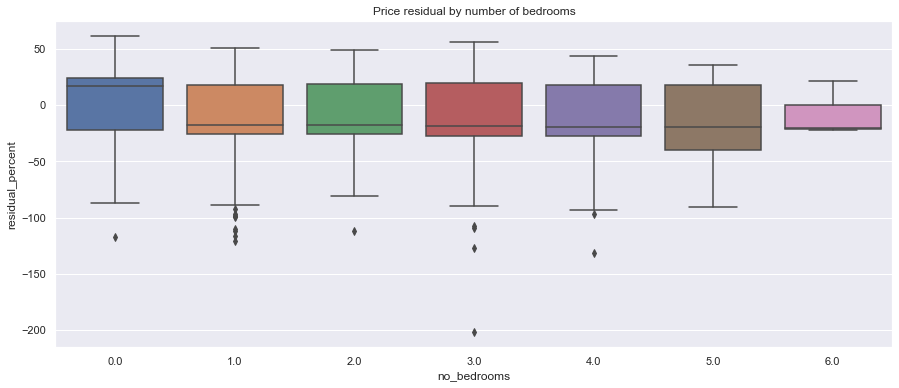

In [149]:
# Plot the residuals on a boxplot, grouped by number of bedrooms
sns.boxplot(data=residuals_df, y ='residual_percent',x='no_bedrooms').set(title='Price residual by number of bedrooms')


The prediction accuracy is the worst for 1 bedroom places. This could be because they are the most common listing size. Another way to segment the listings would be by square footage. The average square footage sizes are:
* Studio apartments: 400-600 sqft
* 1 bedroom apartments: 700-800 sqft
* 2 bedroom apartments: 900- 1200 sqft
* 3+ bedroom apartments: 1300 sqft+

[Text(0.5, 1.0, 'Price residual by listing square footage')]

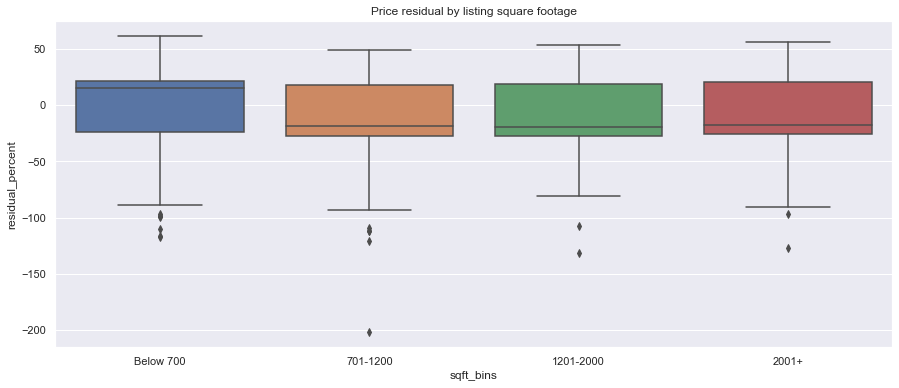

In [150]:
# Plot the residuals on a boxplot, grouped by bins of square footage values
bins = [0, 700, 1200, 2000, float('Inf')]
bin_labels = ['Below 700','701-1200','1201-2000','2001+']
residuals_df['sqft_bins'] = pd.cut(residuals_df['listing_sqft'], bins=bins, labels=bin_labels)
sns.boxplot(data=residuals_df, y ='residual_percent',x='sqft_bins').set(title='Price residual by listing square footage')


This plot suggests the high residuals appear in the lower square footage listings.

In [151]:
# Look at residuals greater than 50%
residuals_50 = residuals_df[(residuals_df['residual_percent'] > 0.5) | (residuals_df['residual_percent'] < -0.5)]
print(f'There are {residuals_50.shape[0]} rows that had residuals greater than 50%')
residuals_50.head()

There are 1283 rows that had residuals greater than 50%


,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh,listing_price_y,sqft_bins
listing_id,,,,,,,,,,,,,,,,,,,,,
7537721764,879.841151,5750,15.301585,More_than_15_percent,2447.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.099660,7612.765499,5750.0,2001+
7507844762,-580.087244,1175,-49.369127,More_than_15_percent,465.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.818314,1775.516109,1175.0,Below 700
7547170537,-656.845943,2627,-25.003652,More_than_15_percent,961.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.305553,3176.636392,2627.0,701-1200
7536604509,447.482871,2145,20.861672,More_than_15_percent,690.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.322691,1602.656920,2145.0,Below 700
7518472286,-1255.859253,7800,-16.100760,More_than_15_percent,3150.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.920537,12349.690668,7800.0,2001+


[Text(0.5, 1.0, 'Distribution of residuals greater than 50% by square footage')]

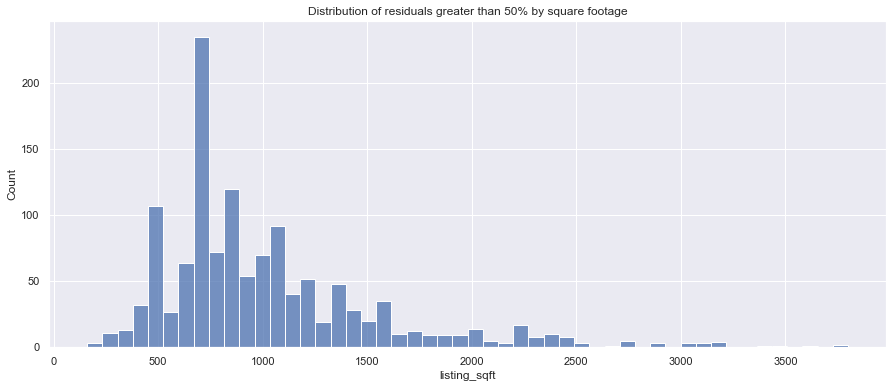

In [152]:
# Plot the price residual distribution of square footage as a histogram
sns.histplot(data=residuals_50, x="listing_sqft", bins=50).set(title='Distribution of residuals greater than 50% by square footage')


This looks like a similar distribution to the plot from EDA for the square footage feature, and there is no obvious cluster of listings that differs from the population distribution. 

[Text(0.5, 1.0, 'Distribution of residuals over 50%')]

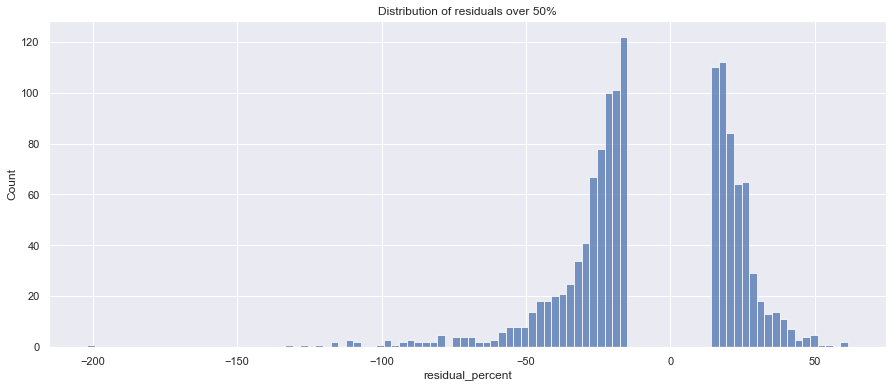

In [153]:
# Plot the distribution of residuals over 50%
sns.histplot(data=residuals_50, x="residual_percent", bins=100).set(title='Distribution of residuals over 50%')


There are more residuals on the left hand side, which suggest the listings are below the predicted market price.

In [154]:
# Plot residuals by neighborhood to see if there is a relationship
nh_df = pd.DataFrame(y_test)
nh_df['predicted_price'] = y_pred_sgd

nh_df = pd.merge(nh_df, df, on = "listing_id", how = "left")
nh_df = nh_df[['listing_nh','listing_price_x','predicted_price']]
nh_df['price_diff'] = nh_df['listing_price_x'] - nh_df['predicted_price']
nh_df['percentage'] = nh_df['price_diff']/nh_df['listing_price_x']
nh_df

# Calculate MAPE 
nh_mape = nh_df.groupby(['listing_nh']).percentage.apply(lambda c: c.abs().mean())*100
nh_mape.sort_values(ascending=False)

# Look at distribution of neighborhoods in the X_train set
nh_size = X_train_preprocess['listing_nh'].value_counts()
nh_size_df = pd.DataFrame({'nh_distribution':nh_size})

# Combine into a df for comparison
nh_df_plot = pd.DataFrame({'nh_mape':nh_mape})
nh_dist = nh_df_plot.merge(nh_size_df, left_index=True, right_index=True, how='left').reset_index()
nh_dist = nh_dist.sort_values(['nh_distribution'], ascending=True)
nh_dist

,listing_nh,nh_mape,nh_distribution
31,"hercules, pinole, san pablo, el sob",2.493323,1.0
6,belmont,98.588567,1.0
10,brentwood / oakley,6.725741,2.0
72,treasure island,3.217696,4.0
61,redwood shores,10.883534,5.0
...,...,...,...
0,SOMA / south beach,17.270529,353.0
7,berkeley,16.514979,420.0
28,half moon bay,12.705976,NaN
36,los altos,21.390940,NaN


There aren't enough data points in some of the smaller neighborhoods, which explains why the MAPE of those neighborhoods are so high. To improve the model, it could make sense to split the neighborhoods into different models.

## 2. Random Forest Regressor

In [155]:
# RandomForestRegressor
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6]
}


model_rf = train_model(RandomForestRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_rf = evaluate_model(model_rf, X_test, y_test)
y_pred_rf = model_rf.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Cross Validation best parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}
R2 score: 0.77
RMSE: 726.98
MAE: 475.85
MAPE: 14.4%


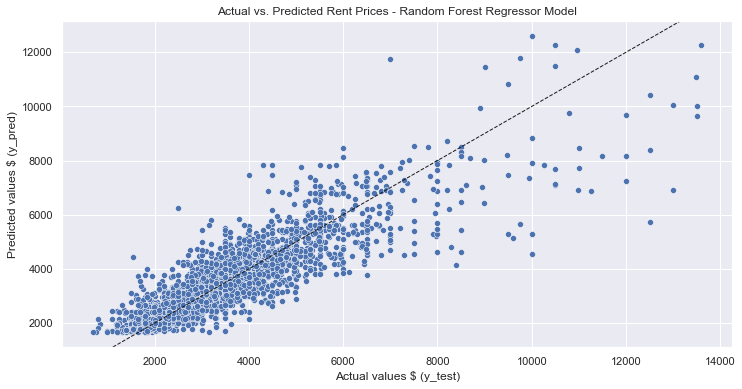

In [156]:
pred_scatterplot(y_pred_rf, y_test, 'Random Forest Regressor')

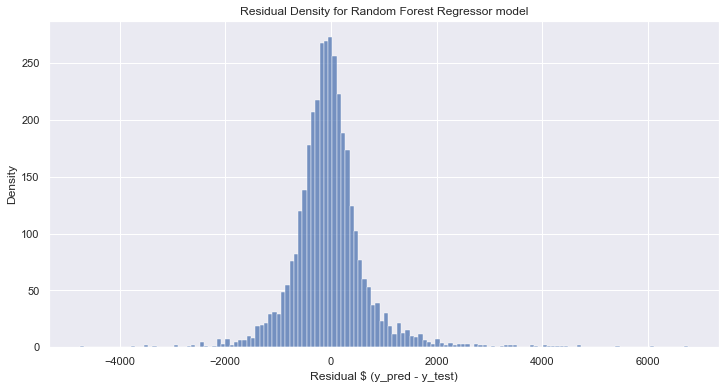

In [157]:
residual_barplot(y_pred_rf, y_test, 'Random Forest Regressor')

## 3. XGBoost Regressor

In [158]:
# XGBoost

param_grid = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200],
             'learning_rate' : [0.001, 0.01, 0.1]}

model_xgb = train_model(xgb.XGBRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_xgb = evaluate_model(model_xgb, X_test, y_test)
y_pred_xgb = model_xgb.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Cross Validation best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
R2 score: 0.82
RMSE: 645.39
MAE: 416.58
MAPE: 12.4%


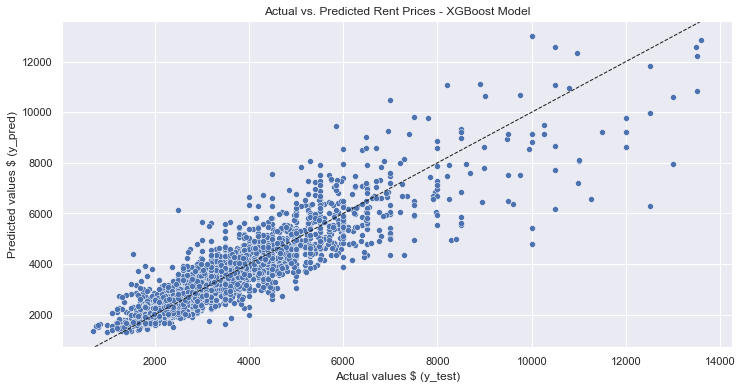

In [159]:
pred_scatterplot(y_pred_xgb, y_test, 'XGBoost')

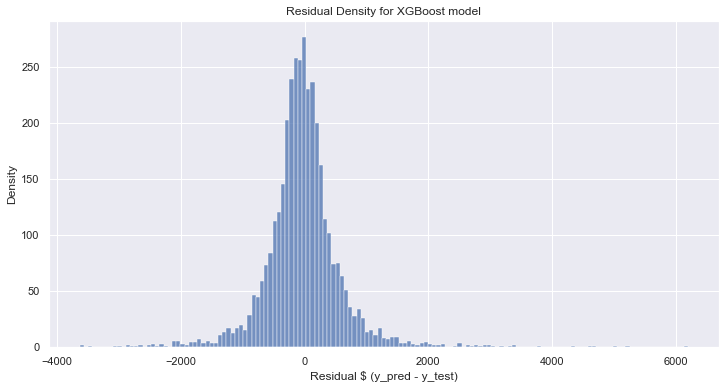

In [160]:
residual_barplot(y_pred_xgb, y_test, 'XGBoost')

## 4. LGBM Regressor

In [161]:
param_grid = {'n_estimators':[10, 50, 100, 500],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             'subsample':[0.5, 0.7, 1.0],
             'max_depth': [2, 3, 4, 5, 6]}

model_lgbm = train_model(lightgbm.LGBMRegressor(), param_grid, 5, 'neg_mean_absolute_percentage_error', X_train, y_train)
metrics_dict_lgb = evaluate_model(model_lgbm, X_test, y_test)
y_pred_lgb = model_lgbm.predict(X_test)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Cross Validation best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.5}
R2 score: 0.82
RMSE: 642.16
MAE: 412.81
MAPE: 12.3%


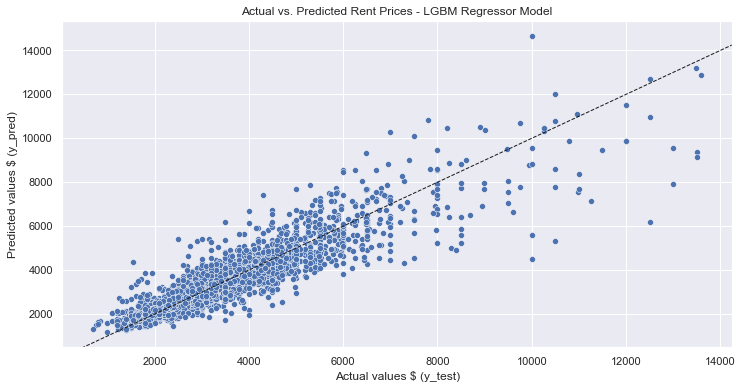

In [162]:
pred_scatterplot(y_pred_lgb, y_test, 'LGBM Regressor')

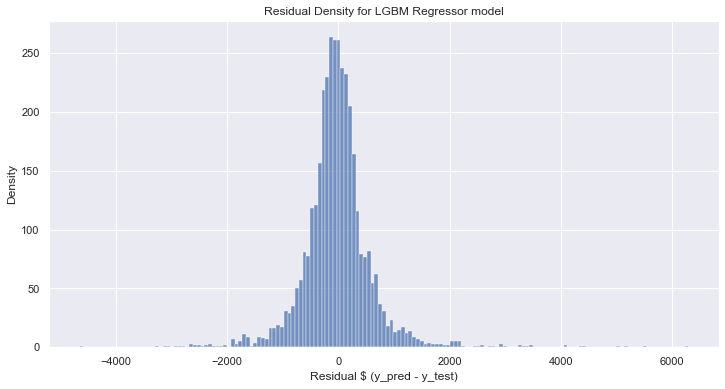

In [163]:
residual_barplot(y_pred_lgb, y_test, 'LGBM Regressor')

# Model Evaluation - test set metrics


In [164]:
# Create a table summarizing the metrics for each machine learning model
metrics_dict_sgd['Model'] = 'Stochastic Gradient Descent'
metrics_dict_rf['Model'] = 'Random Forest Regressor'
metrics_dict_xgb['Model'] = 'XGBoost'
metrics_dict_lgb['Model'] = 'LGBM Regressor'

metrics_d = [metrics_dict_sgd, metrics_dict_rf, metrics_dict_xgb, metrics_dict_lgb]
score_tab = pd.DataFrame(metrics_d)
score_tab

,Model,R2 score,RMSE score,MAE score,MAPE score %
0,Stochastic Gradient Descent,0.777376,715.254265,467.055226,14.180648
1,Random Forest Regressor,0.770019,726.977344,475.853783,14.352198
2,XGBoost,0.818746,645.385402,416.584216,12.370289
3,LGBM Regressor,0.820552,642.160492,412.807100,12.284365


Text(0.5, 1.0, 'Residual Density by Model')

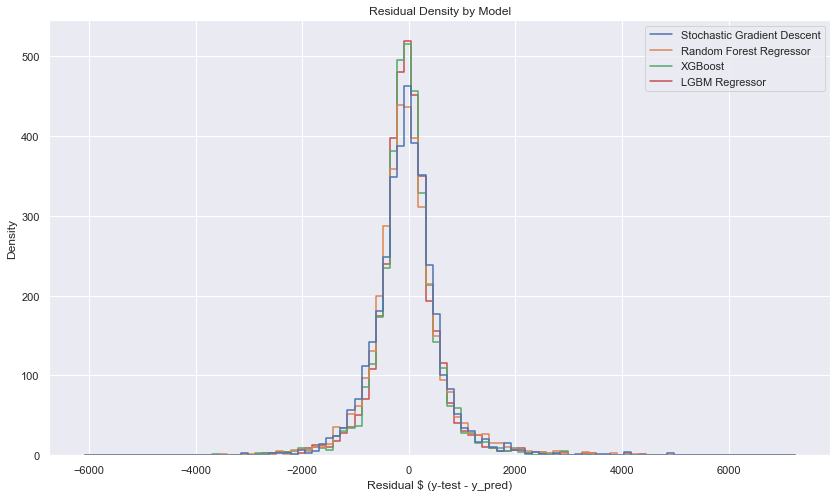

In [165]:
d = {"Stochastic Gradient Descent": y_test-y_pred_sgd, "Random Forest Regressor": y_test-y_pred_rf, "XGBoost": y_test-y_pred_xgb, "LGBM Regressor": y_test-y_pred_lgb}
models_pred = pd.DataFrame(d)

# Create a histplot of the residual densities comparing the performance of each of the models
sns.set(rc={"figure.figsize":(14, 8)})
s = sns.histplot(models_pred, bins=100, element="step", fill=False)
plt.ylabel('Density')
plt.xlabel('Residual $ (y-test - y_pred)')
plt.title('Residual Density by Model')


The conclusion:
The XGBoost and LGBM Regressor both performed well. An average prediction error of 12% is pretty good for one model on a wide range of listing sizes and locations. 











# Feature Exploration

Look at the linear regression model and the feature coefficients to see if they make sense:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

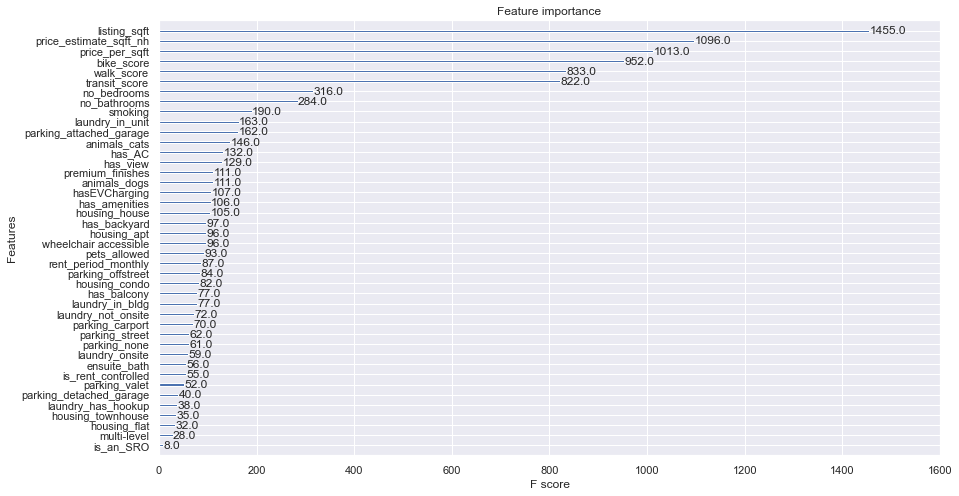

In [168]:
# Look at the feature importances using the built in XGBoost Feature Importance Plot

# plot feature importance
xgb.plot_importance(model_xgb)

The top features in the model are the size of the property i.e. square footage and number of bedrooms/bathrooms, and features to do with the location - the "expensiveness" of the neighborhood and the proximity to shops and transit.

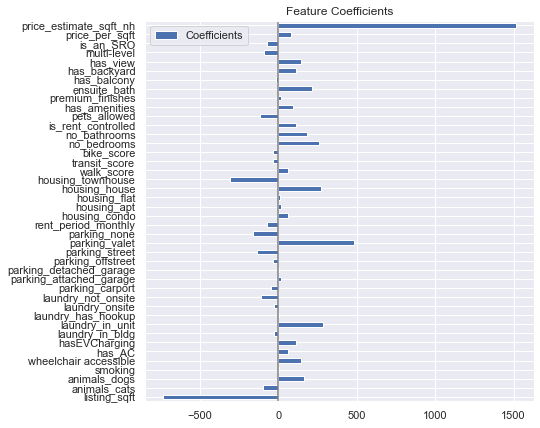

In [186]:
# Plot feature importance for stochastic gradient descent model
coefs = pd.DataFrame(
   model_sgd.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [170]:
model_sgd.coef_

array([-736.93311594,  -99.94927379,  166.9030952 ,    3.99906825,
        144.49343311,   63.54007215,  116.32103052,  -28.78129474,
        285.71899141,    6.00905829,  -24.73515168, -108.2428793 ,
        -45.69415637,   19.34772278,    2.80523241,  -30.17125826,
       -134.8371088 ,  481.53636415, -163.01806499,  -73.00015315,
         64.6262196 ,   20.20021728,   10.82188538,  269.64904998,
       -304.76982168,   60.22402405,  -35.27679381,  -32.39386777,
        257.75799311,  180.78438438,  114.27397239, -115.86445294,
         94.89546844,   15.59534368,  217.81976425,  -16.28402383,
        113.59194394,  144.39580764,  -90.54058076,  -71.75986084,
         84.29851974, 1516.40174321])

In [171]:
X_train.head(8)

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh
listing_id,,,,,,,,,,,,,,,,,,,,,
7540947998,-0.638730,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.275789,-0.526374
7521266991,-1.088737,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.028558,-1.215431
7536497502,-1.088737,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1.275804,-0.802526
7548144379,-0.871128,0,0,1,0,0,1,0,1,0,...,1,1,0,0,0,0,0,0,-0.449012,-0.920352
7536588638,-0.670421,1,1,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,-1.891344,-1.113177
7537182955,0.487344,0,0,0,0,0,0,0,1,0,...,1,1,0,1,0,1,0,0,1.248366,1.068708
7517834699,-0.530982,1,1,1,0,0,0,0,1,0,...,1,1,0,1,0,1,0,0,-1.090566,-0.802081
7509986472,-0.416896,1,1,0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0.283887,-0.299462


In [172]:
y_train.head(8)

listing_id
7540947998    2395
7521266991    1575
7536497502    1895
7548144379    2000
7536588638    1730
7537182955    5200
7517834699    2300
7509986472    3480
Name: listing_price, dtype: int64

In [173]:
y_test

listing_id
7537721764    5750
7511018326    3988
7507844762    1175
7512271587    4695
7547170537    2627
              ... 
7540201361    2895
7537691238    3400
7547516171    3100
7536567615    1550
7544078771    2008
Name: listing_price, Length: 3719, dtype: int64

In [174]:
# X_test.index.get_loc(7521959344)
# y_test.loc[7521959344]

In [175]:
def explain(model, X, y, listing_id):
    row = X.loc[listing_id]
    idx = X.index.get_loc(listing_id)
#     y_actual = y[idx]
    y_actual = y.loc[listing_id]
    y_pred = model.predict(X)[idx]
    contributions = [
        (feature, row[i] * model.coef_[i])
        for i, feature in enumerate(X.columns)
    ]
    print(f'y_actual : {y_actual}')
    print()
    print(f'y_pred : {y_pred}')
    print(f'intercept : {model.intercept_}')
    for feature, contribution in sorted(contributions, reverse=True, key=lambda c: abs(c[1])):
        if (abs(contribution)) > 0.1:
            print(f'{feature} : {contribution:.2f}')

Look at a specific listing to see the price contributions of each feature. In this case, the predicted price is lower than the actual listing price

In [176]:
# explain(sgd, X_train, y_train, 7521959344)

In [177]:
# X_test.loc[7521959344]

In [179]:
# Look at the feature coefficients of a specific listing_id
# explain(sgd, X_test, y_test, 7521959344)

In [180]:
sgd.feature_names_in_

array(['listing_sqft', 'animals_cats', 'animals_dogs', 'smoking',
       'wheelchair accessible', 'has_AC', 'hasEVCharging',
       'laundry_in_bldg', 'laundry_in_unit', 'laundry_has_hookup',
       'laundry_onsite', 'laundry_not_onsite', 'parking_carport',
       'parking_attached_garage', 'parking_detached_garage',
       'parking_offstreet', 'parking_street', 'parking_valet',
       'parking_none', 'rent_period_monthly', 'housing_condo',
       'housing_apt', 'housing_flat', 'housing_house',
       'housing_townhouse', 'walk_score', 'transit_score', 'bike_score',
       'no_bedrooms', 'no_bathrooms', 'is_rent_controlled',
       'pets_allowed', 'has_amenities', 'premium_finishes',
       'ensuite_bath', 'has_balcony', 'has_backyard', 'has_view',
       'multi-level', 'is_an_SRO', 'price_per_sqft',
       'price_estimate_sqft_nh'], dtype=object)

In [181]:
feature_coef_dict = {}

# Compare feature coefficients looking at the difference between when the feature is incremented by 1 unit
def get_feature_raw_coefficients(feature_transformer, model):
    features = model.feature_names_in_
    X_base = pd.DataFrame.from_records([[0]*len(features)], columns=features)
    y_base = model.predict(feature_transformer.transform(X_base))
    for i, feature in enumerate(features):
        feature_values = [[0]*len(features)]
        feature_values[0][i] = 1
        X = pd.DataFrame.from_records(feature_values, columns=features)
        y = model.predict(feature_transformer.transform(X))
#         print(f'{feature} : {y[0] - y_base[0]}')
        feature_coef_dict[feature] = y[0] - y_base[0]
    return feature_coef_dict

# Look at the feature coefficients per unit increase in feature for the Stochastic Gradient Descent model sgd
# The feature coefficients represent the dollar price change for that feature
get_feature_raw_coefficients(scale, sgd)

{'listing_sqft': -1.588645287954023,
 'animals_cats': -92.80657878251759,
 'animals_dogs': 182.80106096106874,
 'smoking': 15.669500421109205,
 'wheelchair accessible': 131.9393938124881,
 'has_AC': 24.23076082142188,
 'hasEVCharging': 131.54370382433035,
 'laundry_in_bldg': -25.27983593671297,
 'laundry_in_unit': 260.3446395544088,
 'laundry_has_hookup': 11.366673422998701,
 'laundry_onsite': 4.042666138501318,
 'laundry_not_onsite': -94.5884025232267,
 'parking_carport': -69.23110859770304,
 'parking_attached_garage': 24.240878036676804,
 'parking_detached_garage': -7.893509516606173,
 'parking_offstreet': -65.42803340290493,
 'parking_street': -171.69579767815821,
 'parking_valet': 622.2838312001281,
 'parking_none': -176.38102229467313,
 'rent_period_monthly': -40.072077492957305,
 'housing_condo': 40.95297530251992,
 'housing_apt': -1.524486339784744,
 'housing_flat': 24.972059257913315,
 'housing_house': 244.95124036381958,
 'housing_townhouse': -286.56303920883965,
 'walk_score'

### Look at the average contribution to the overall rental price of features of interest 
Features of interest:
* Allows pets
* Is wheelchair accessible
* Allows smoking
* Has Air Conditioning
* Has EV charging
* Has laundry in-unit
* Has offstreet parking
* Has Valet parking
* Has a high walk score/transit score (define high as ?, no car dependency)
* Has amenities
* Has premium finishes
* Has a backyard
* Has a view

In [182]:
# Convert dictionary to DataFrame
model_coef = pd.DataFrame(list(feature_coef_dict.items()))
model_coef.columns = ['feature','model_coef']
model_coef.set_index('feature', inplace=True)

model_coef

,model_coef
feature,
listing_sqft,-1.588645
animals_cats,-92.806579
animals_dogs,182.801061
smoking,15.669500
wheelchair accessible,131.939394
has_AC,24.230761
hasEVCharging,131.543704
laundry_in_bldg,-25.279836
laundry_in_unit,260.344640


In [183]:
# Calculate metrics of parking that is a designated parking location but not street parking
has_offstreet_parking = ['parking_carport', 'parking_attached_garage','parking_detached_garage', 'parking_offstreet']

# Calculate weighted average feature coefficient of non street parking
# How often do the features appear in X_train?
X_train_len = X_train.shape[0]
parking_coef = 0

for parking_option in has_offstreet_parking:
    parking_coef += (model_coef.loc[parking_option] * X_train[parking_option].sum())/X_train_len


model_coef.loc['non_street_parking'] = parking_coef

features_of_interest = ['animals_cats','animals_dogs','pets_allowed','smoking','wheelchair accessible','has_AC','hasEVCharging',
       'laundry_in_unit', 'parking_valet', 'non_street_parking', 'has_amenities', 'premium_finishes', 'has_backyard', 'has_view']

model_coef = model_coef.loc[features_of_interest]
model_coef

,model_coef
feature,
animals_cats,-92.806579
animals_dogs,182.801061
pets_allowed,-122.005774
smoking,15.669500
wheelchair accessible,131.939394
has_AC,24.230761
hasEVCharging,131.543704
laundry_in_unit,260.344640
parking_valet,622.283831


Text(0.5, 1.0, '$ Price change per 1 unit change in features')

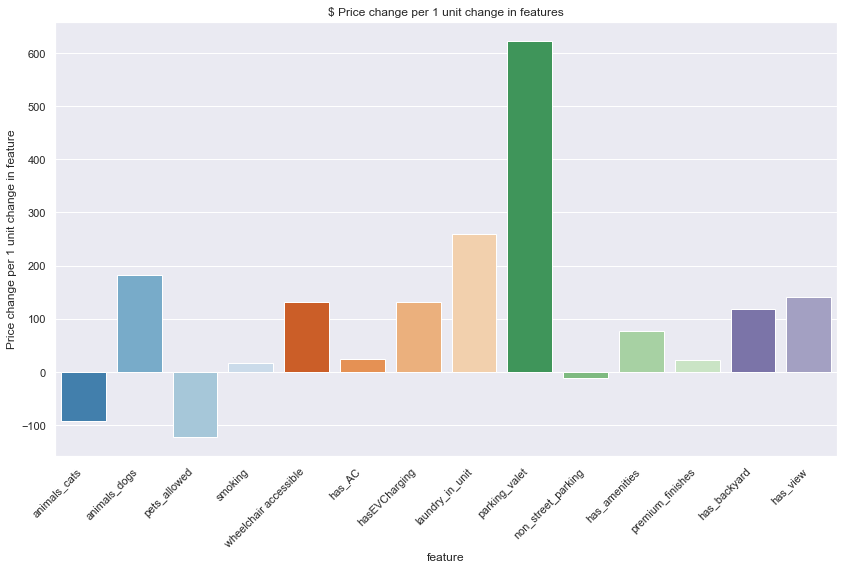

In [193]:
# Plot the model coefficients for each feature
chart = sns.barplot(data=model_coef.reset_index(), x="feature", y="model_coef", palette = 'tab20c')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel('Price change per 1 unit change in feature')
chart.set_title('$ Price change per 1 unit change in features')

Some interesting feature coefficients are valet parking which has a 600+ dollar premium, and wheelchair accessible listings have more than 100 dollar premium. 